In [64]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from importlib import reload
import utils ; reload(utils)
from utils import *
%matplotlib inline

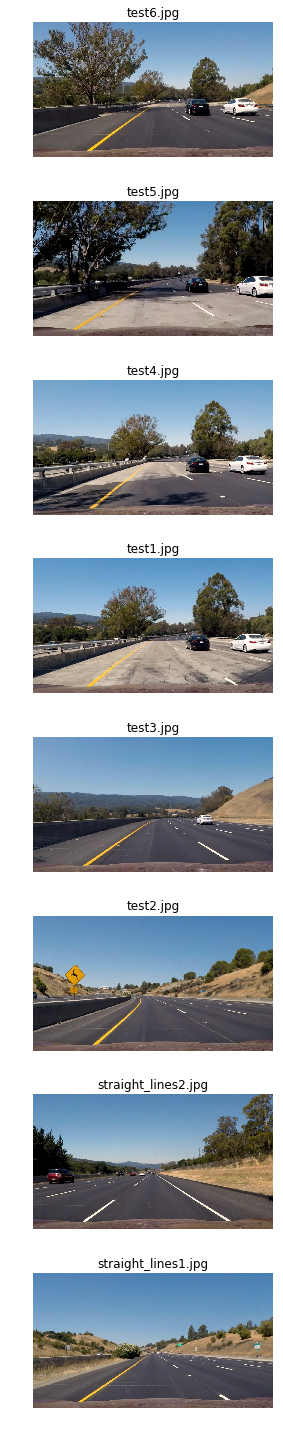

In [65]:
base_path = '/Users/henke/Documents/code/udacity_self-driving_car/CarND-Advanced-Lane-Lines/'
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
test_path = base_path + test_imgs_dir
calibration_path = base_path + calibration_dir
output_imgs_path = base_path + output_imgs_dir

nx = 9
ny = 6
def plot_all_testimgs(fun, persist=False, postfix=''):
    imgs = []
    titles = []
    for img_path in get_images_paths(test_path, '*.jpg'):
        img = get_image(img_path) 
        imgs.append([fun(img)])
        titles.append([img_path.rsplit('/', 1)[-1]])
    plot_list(imgs, titles, size=(20,20), persist=persist, plotname=postfix)
plot_all_testimgs(lambda x: x)

### Functions for camera calibration and image distortion

In [3]:
def find_chessboard_corners(img, nx, ny):
    '''
    img is a grayscale image and return ret tru if any corners found and corners is the coordinate of that corner
    '''
    ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)
    return ret, corners

def get_img_and_obj_points(imgs_paths, nx, ny):
    '''
    Compute the image points and object points from a set of calibration images nx and ny indicate the number of inner corners
    '''
    # Array to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object point like (0,0,0), (1,0,0) ...
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # z will stay att zero, but x and y should count up (0,0,0), (1,0,0) ...

    num_images_where_corners_found = 0
    print('Number of calibration images: {}'.format(len(imgs_paths)))
    gray = 0
    for img_path in imgs_paths:
       img = get_image(img_path)
       gray = convert_to_grayscale(img)
       ret, corners = find_chessboard_corners(gray, nx, ny)
       if ret == True:
           num_images_where_corners_found += 1
           imgpoints.append(corners)
           objpoints.append(objp)
    print('Number of images where corners where found: {}'.format(num_images_where_corners_found))
    return objpoints, imgpoints, gray.shape[::-1]

def get_cameramatrix_and_distortion_coeffs(cal_imgs_paths, nx, ny):
    objpoints, imgpoints, dim = get_img_and_obj_points(cal_imgs_paths, nx, ny)
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, dim,None,None)
    return cameraMatrix, distCoeffs

def undistort_img(img, mtx, dist):
    '''
    returns the undistorted destination img
    '''
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [4]:
# Testing image calibration
imgs_paths_cal = sorted(get_images_paths(calibration_path, 'calibration*.jpg'))
mtx, dist = get_cameramatrix_and_distortion_coeffs(imgs_paths_cal, nx, ny)

Number of calibration images: 20
Number of images where corners where found: 17


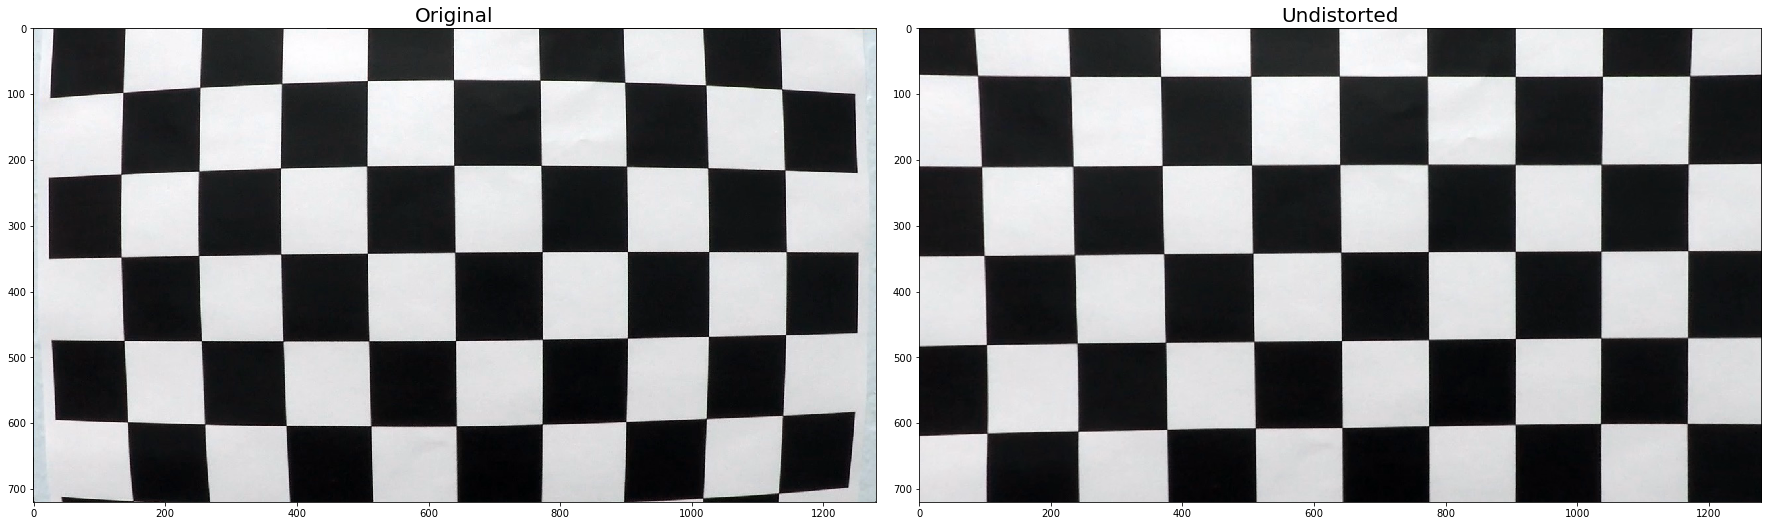

In [5]:
output = False
if output:
    #Output all images as test images
    imgs_paths_test = get_images_paths(test_path, '*.jpg')
    # First test on calibration images
    if 'calibration1.jpg' in imgs_paths_cal[0]:
        img = get_image(imgs_paths_cal[0])
        undistorted_img = undistort_img(img, mtx, dist)
        # Showing a sample of undistroted image
        plt.imshow(undistorted_img)
        output_image(undistorted_img ,output_imgs_path, 'calibration1')
    # Then run on all test images
    for idx, path in enumerate(imgs_paths_test):
        img = get_image(path)
        undistorted_img = undistort_img(img, mtx, dist)
        output_image(undistorted_img ,output_imgs_path, 'test' + str(idx))
else:
    # Plot example image of distorted and undistorted
    img = cv2.imread('./camera_cal/calibration1.jpg')
    ex_undistorted = undistort_img(img, mtx, dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original', fontsize=20)
    ax2.imshow(ex_undistorted)
    ax2.set_title('Undistorted', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Thresholding
### Color thresholding

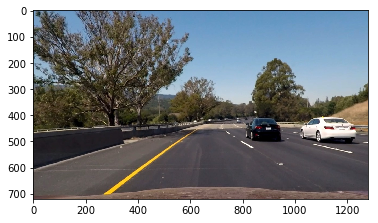

In [6]:
# Get the test image
test6_path = get_images_paths(test_path, 'test6*')
test6_img_dist = get_image(test6_path[0])
test6_img = undistort_img(test6_img_dist, mtx, dist)
plt.imshow(test6_img);

### Test different color spaces 

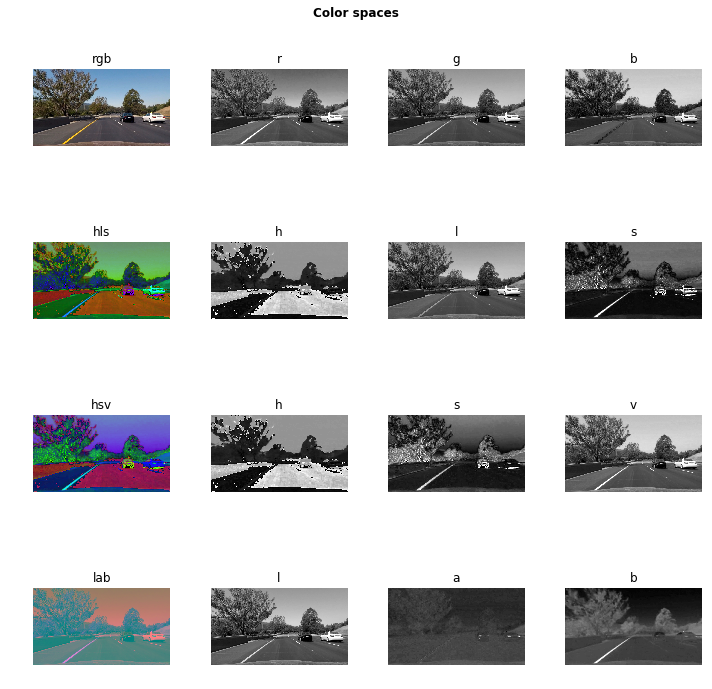

In [7]:
rgb = test6_img
r = rgb[:,:,0]
g = rgb[:,:,1]
b = rgb[:,:,2]
hls = convert_to_hls(rgb)
h = hls[:,:,0]
l = hls[:,:,1]
s = hls[:,:,2]
hsv = convert_to_hsv(rgb)
h_ = hsv[:,:,0]
s_ = hsv[:,:,1]
v_ = hsv[:,:,2]
lab = convert_to_lab(rgb)
l_ = lab[:,:,0]
a_ = lab[:,:,1]
b_ = lab[:,:,2]
imgs = [
    [rgb,r,g,b],
    [hls,h,l,s],
    [hsv,h_,s_,v_],
    [lab,l_,a_,b_]]
titles = [
    ['rgb','r','g','b'],
    ['hls','h','l','s'],
    ['hsv','h','s','v'],
    ['lab','l','a','b']]

title = 'Color spaces'
plot_list(imgs,titles,title)

### Binary mask of different thresholds 

In [8]:
def threshold_img(img, channel, threshold=(0, 255)):
    '''
    apply a binary mask to img and return a binary image from
    selected channel
    '''
    xchan = img[:,:,channel]
    binary = np.zeros_like(xchan)
    binary[(xchan > threshold[0]) & (xchan <= threshold[1])] = 1
    return binary

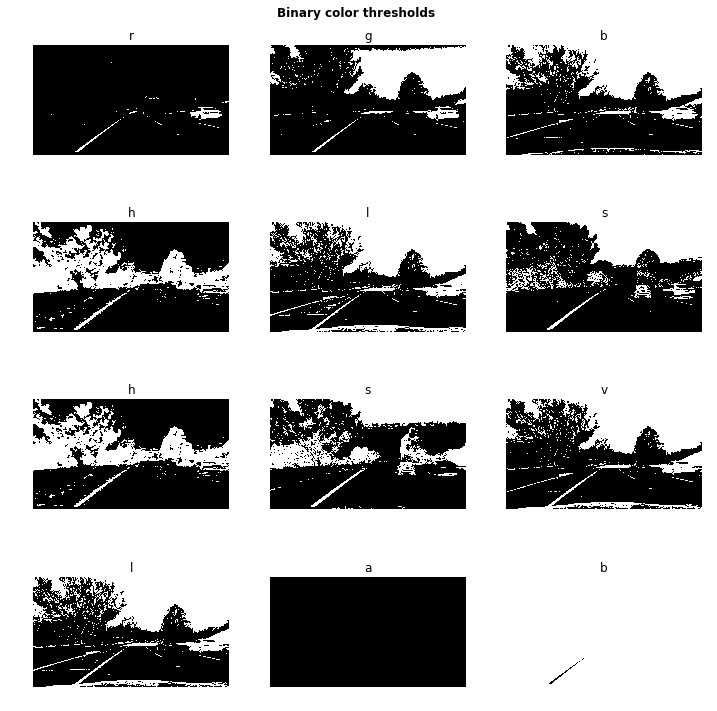

In [9]:
rt = threshold_img(rgb, 0, threshold=(200, 255))
gt = threshold_img(rgb, 1, threshold=(150, 255))
bt = threshold_img(rgb, 2, threshold=(100, 255))
ht = threshold_img(hls, 0, threshold=(15, 100))
lt = threshold_img(hls, 1, threshold=(100, 255))
st = threshold_img(hls, 2, threshold=(90, 255))
h_t = threshold_img(hsv, 0, threshold=(15, 100))
s_t = threshold_img(hsv, 1, threshold=(90, 255))
v_t = threshold_img(hsv, 2, threshold=(120, 255))
l_t = threshold_img(lab, 0, threshold=(110, 255))
a_t = threshold_img(lab, 1, threshold=(80, 90))
b_t = threshold_img(lab, 2, threshold=(90, 200))
imgs = [
    [rt,gt,bt],
    [ht,lt,st],
    [h_t,s_t,v_t],
    [l_t,a_t,b_t]]
titles = [
    ['r','g','b'],
    ['h','l','s'],
    ['h','s','v'],
    ['l','a','b']]
title = 'Binary color thresholds'
plot_list(imgs,titles,title)

### Combine the best color thresholds and test on test imgs

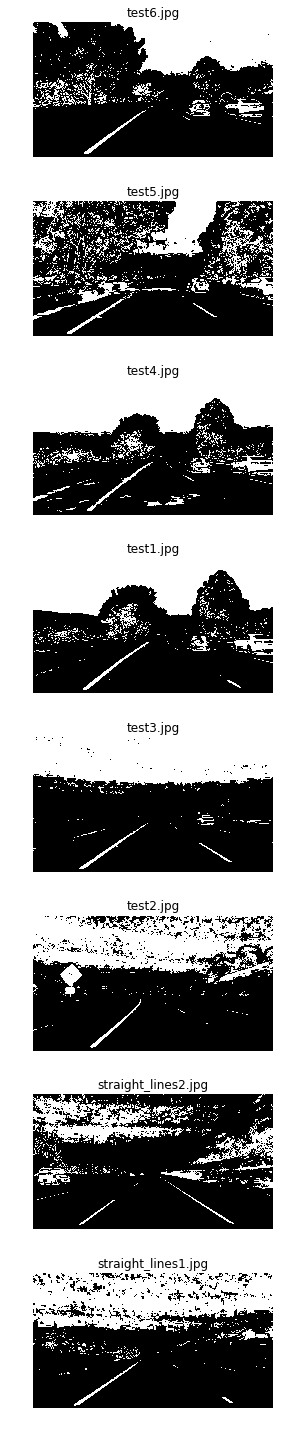

In [86]:
def best_color_thresholds(undistorted_img):
    rt = threshold_img(undistorted_img, 0, threshold=(220, 255))
    hls = convert_to_hls(undistorted_img)
    st = threshold_img(hls, 2, threshold=(100, 255))
    color_combined = np.zeros_like(rt)
    color_combined[(st == 1) | (rt == 1)] = 1
    return color_combined

def fun_for_testimages1(img):
    und = undistort_img(img, mtx, dist)
    return best_color_thresholds(und)
plot_all_testimgs(fun_for_testimages1)

## Gradient thresholding
We use three different gradient calculations, Absolut value of Sobel in x and y direction,
gradient magnitude and gradient direction

In [69]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    '''
    Calculate soble operation on a single channel image 
    and takes the absolut value and apply threshold to return binary image
    '''
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    Calculate soble matrix on a single channel image using both x and y direction then computes the magnitudes
    in both directions and apply threshold and return the binary result
    '''
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Apply threshold
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    Calculate soble matrix on a single channel image using both x and y direction then computes the magnitudes
    in both directions and uses the absolut value to find the direction of the gradient
    and then apply threshold and return the binary result
    '''
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Apply threshold
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

### Gradient thresholds 

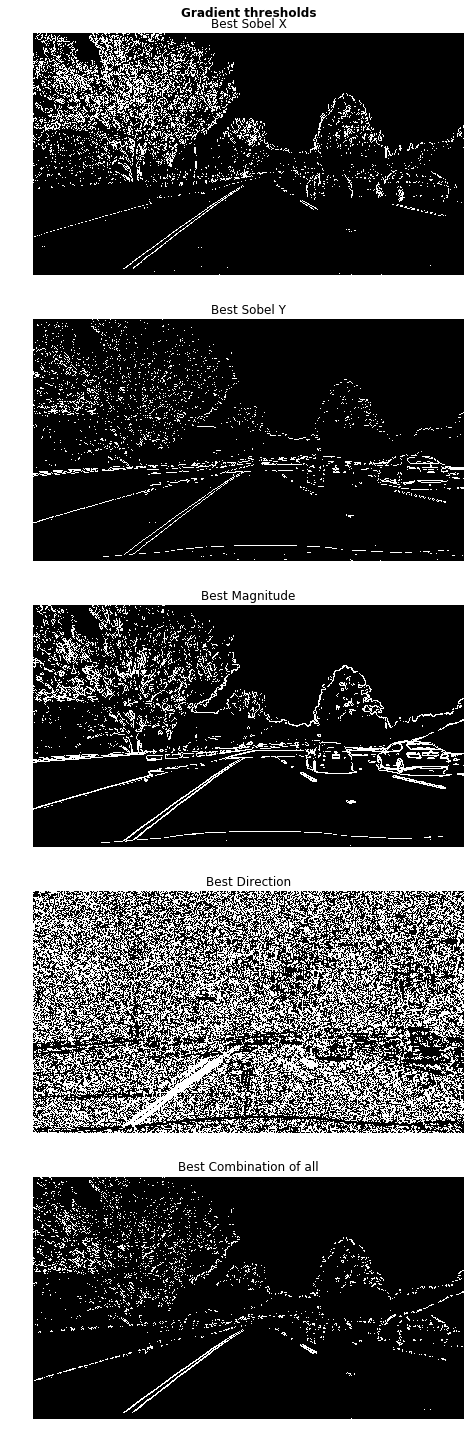

In [70]:
# Using gray images has been shown to loose information about line 
# colors so we want to try and find a different color space lets try labs l channel
gradx = abs_sobel_thresh(l_, orient='x', thresh=(25, 100))
grady = abs_sobel_thresh(l_, orient='y', thresh=(50, 150))
mag_binary = mag_thresh(l_, sobel_kernel=9, mag_thresh=(50, 250))
dir_binary = dir_threshold(l_, sobel_kernel=15, thresh=(0.5, 1.3))
    
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
imgs = [
    [gradx],
    [grady],
    [mag_binary],
    [dir_binary],
    [combined]]
titles = [
    ['Best Sobel X'],
    ['Best Sobel Y'],
    ['Best Magnitude'],
    ['Best Direction'],
    ['Best Combination of all']]
title = 'Gradient thresholds'
plot_list(imgs,titles,title,size=(20,20))

### Combining color and gradient thresholds and test on images

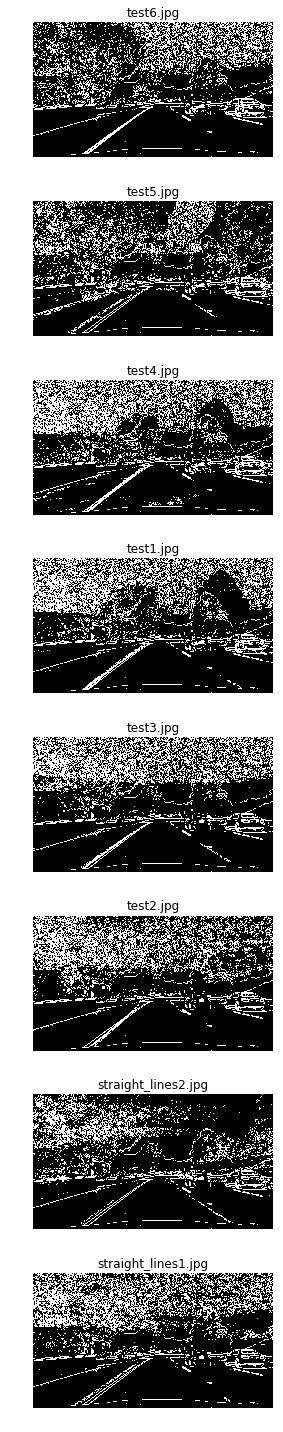

In [87]:
def combine_gradient_thresholds(l_channel):
    '''
    get as input a single channel image
    '''
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(l_, orient='x', thresh=(25, 100))
    grady = abs_sobel_thresh(l_, orient='y', thresh=(50, 150))
    mag_binary = mag_thresh(l_, sobel_kernel=9, mag_thresh=(50, 250))
    dir_binary = dir_threshold(l_, sobel_kernel=15, thresh=(0.5, 1.3))
    # Decide what need to meet the criteria
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1))] = 1
    return combined
def combine_gradient_color_threshold(undistorted_rgb_img):
    '''
    Take in a rgb image, convert to lab and apply color 
    and gradient thresholding and return the binary image
    of the best combination.
    '''
    # Gradient thresholds
    lab_img = convert_to_lab(undistorted_rgb_img)
    l_channel = lab_img[:,:,0]
    combined_gradient_binary = combine_gradient_thresholds(l_channel)
    # Color threshold
    color_combined = best_color_thresholds(undistorted_rgb_img)

    # Combine the two binary thresholds of colors and gradients
    combined_binary = np.zeros_like(color_combined)
    combined_binary[(combined_gradient_binary == 1) | (color_combined == 1) & (dir_binary == 1)] = 1
    return combined_binary
def fun_for_testimages2(img):
    und = undistort_img(img, mtx, dist)
    return combine_gradient_color_threshold(und)
plot_all_testimgs(fun_for_testimages2, persist=True, postfix='threshold')

In [72]:
imm = np.zeros(shape=(10,10))
if len(imm.shape) < 3:
    imm = np.expand_dims(imm,axis=2)
imm.shape

(10, 10, 1)

# Perspective transform
After having a combined binary image its time to transform the perspective to a bird eyes view
to make is easier to decide on curvature of lines.

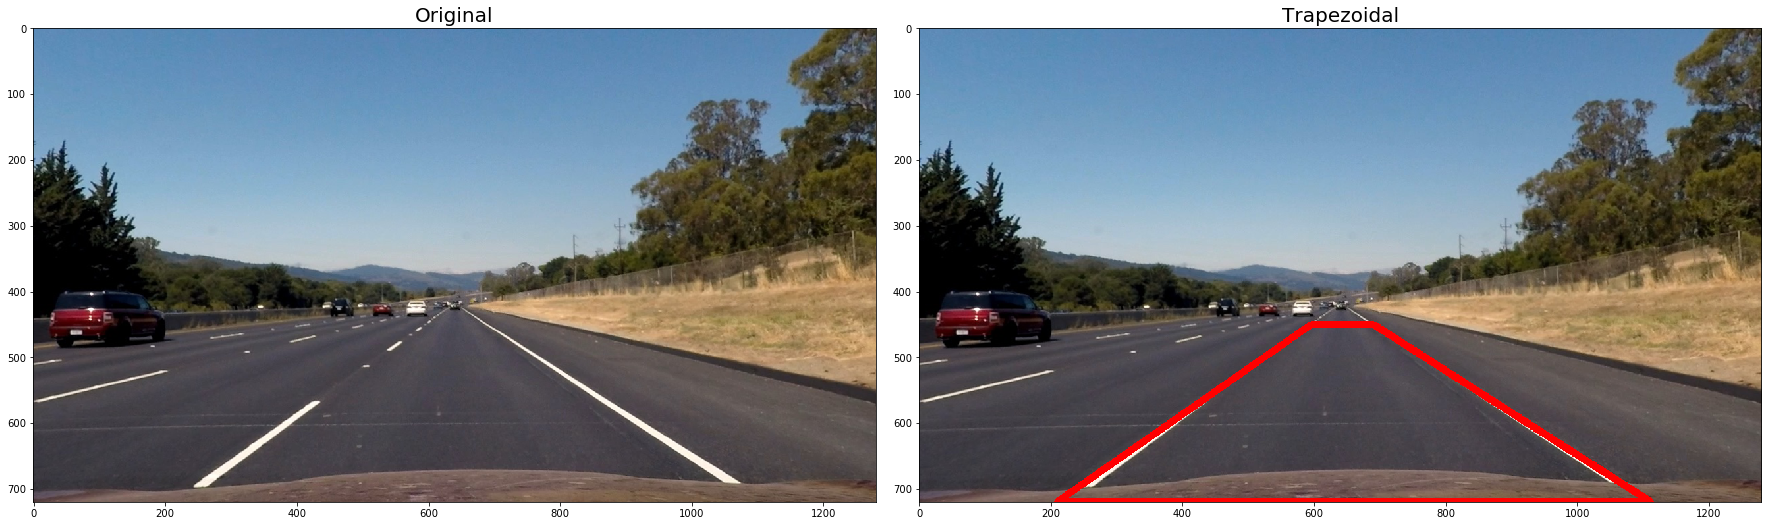

In [91]:
# Find a test image that has straight lines in it
straight_path = get_images_paths(test_path, 'straight_lines2*')
straight_img_dist = get_image(straight_path[0])
straight_img = undistort_img(straight_img_dist, mtx, dist)
# Trial and error to find good points
bottom, _ = (img.shape[0] - 1, img.shape[1] - 1)
pts = np.array([[210,bottom],[595,450],[690,450], [1110, bottom]], np.int32)
def draw_trapezoidal(img): 
    return cv2.polylines(img,[pts],True,(255,0,0), 10)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(straight_img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(draw_trapezoidal(straight_img))
ax2.set_title('Trapezoidal', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

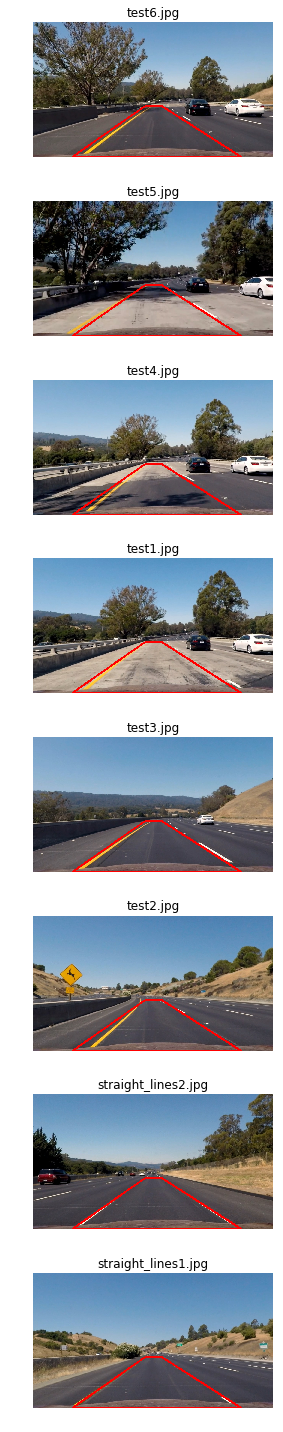

In [76]:
# Test Trapezoidal on all test images
def fun_for_testimages3(img):
    und = undistort_img(img, mtx, dist)
    return draw_trapezoidal(und)
plot_all_testimgs(fun_for_testimages3)

In [77]:
def get_perspective_trasform_matricies(src, dst):
    '''
    Return transformation matrice and the inverse 
    matrise given sourc and destination points
    '''
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv
def warp(img, M):
    '''
    Takes as input an image source and destination point and return a 
    perspective transformed image, M matrix and the invers M matrix
    '''
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

src = pts.astype(np.float32)
dst = np.array([[200, bottom], [200, 0], [1000, 0], [1000, bottom]], np.float32)
M, _ = get_perspective_trasform_matricies(src, dst)



### Test perspective transform on original image

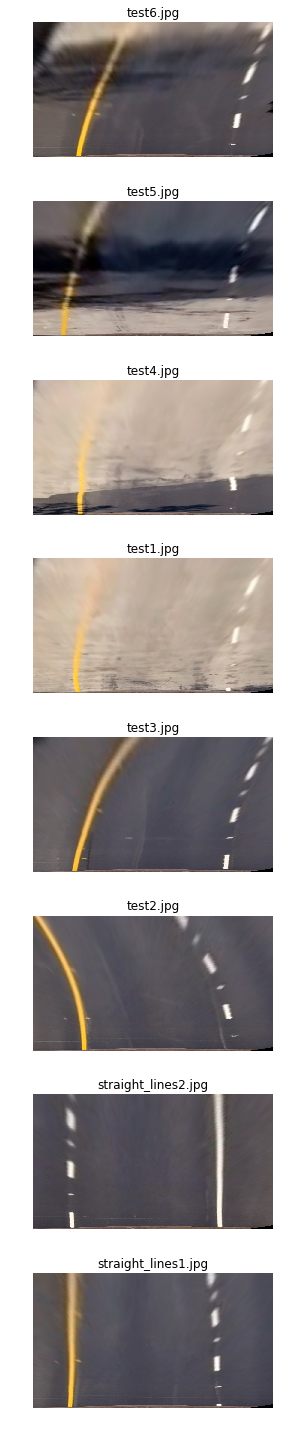

In [78]:
def fun_for_testimages4(img):
    und = undistort_img(img, mtx, dist)
    return warp(und, M)
plot_all_testimgs(fun_for_testimages4)

### Test perspective transform on binary image

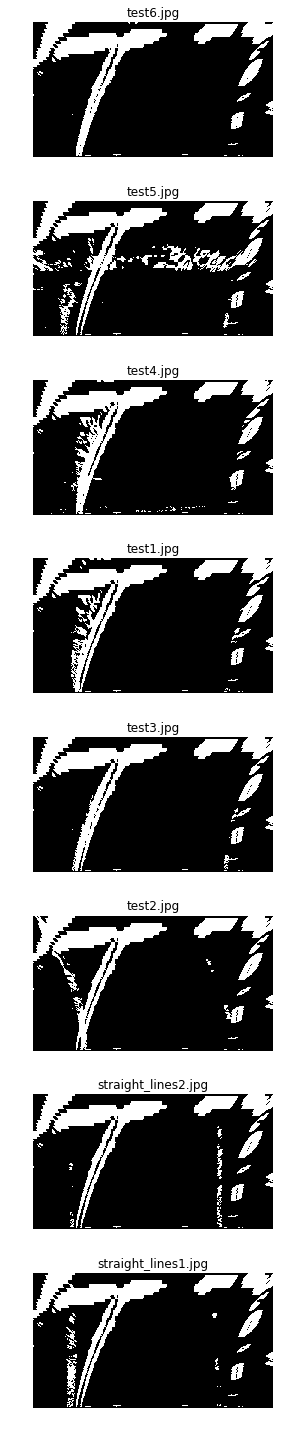

In [88]:
def fun_for_testimages5(img):
    und = undistort_img(img, mtx, dist)
    threshold = combine_gradient_color_threshold(und)
    return warp(threshold, M)
plot_all_testimgs(fun_for_testimages5)

# Finding the lines
How can we identify the lines in the image? We could try to use the
bird eyes view image in binary form and plot a historgram over pixel intensity

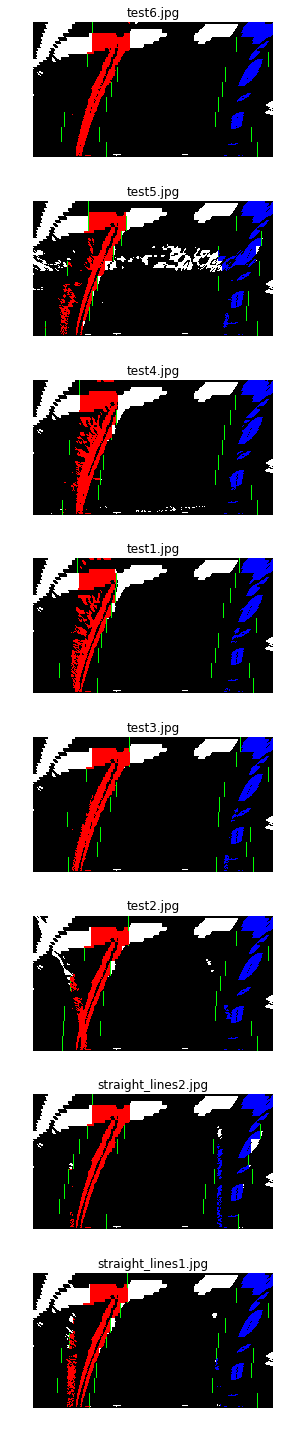

In [89]:
def find_lanes(binary_warped):
    '''
    Tries to fit a second order polynomial to the lanes
    '''
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img
plot_all_testimgs(lambda img: find_lanes(fun_for_testimages5(img)))

# Finding the lines

In [82]:
import math
class LaneFinder():
    def __init__(self, src, dst, mtx, dist):
        # Config data
        self.mtx = mtx
        self.dist = dist
        
        # Images for each frame
        self.undistorted_img = None
        self.fitted_lines_thresholded_warped_img = None
        
        # The perspective transform matrix
        self.M, self.Minv = get_perspective_trasform_matricies(src, dst)
        
        # If this is the first frame processed
        self.initial_frame = True
        
        # Set from lane detection
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None

    def process_frame(self, img):
        '''
        Implementation of full pipeline to detect trafic lines
        '''
        # Undistort image
        self.undistorted_img = undistort_img(img, self.mtx, self.dist)
        
        # Make binary threshold
        binary_img = combine_gradient_color_threshold(self.undistorted_img)
        
        # Warp both rgb and binary image
        #warped, self.M, self.Minv = warp(img, self.src, self.dst) # For plotting in video to debug
        warped_binary = warp(binary_img, self.M)
    
        # Entry point for making all calculations
        self._fit_lines(warped_binary)
        
        warped_undistorted = warp(self.undistorted_img, self.M) # Just used for visual feedback
        self._draw_miniimages(warped_undistorted, self.fitted_lines_thresholded_warped_img)
        return self.undistorted_img
    def _fit_lines(self, binary_warped):
        '''
        Make a polynomal fit on the lane curves for the first frame
        '''
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Set the width of the windows +/- margin
        margin = 100
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        if self.initial_frame:
            # Only run this once
            self.initial_frame = False
            # Get histogram of bottom half of image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

            # Find left peek and right peek in histogram
            midpoint = np.int(histogram.shape[0]//2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Choose the number of sliding windows
            nwindows = 9
            window_height = np.int(binary_warped.shape[0]//nwindows)
            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                #(0,255,0), 2) 
                #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                #(0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        else:
            left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        # Below is code for plotting miniature image
        #################################################
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        self.fitted_lines_thresholded_warped_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        self._calculate_curvature(binary_warped)

    def _calculate_curvature(self, binary_warped):
        '''
        Calculate the curvature and center offset for the car
        '''
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        y_eval = np.max(ploty)
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, self.left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, self.right_fitx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature in meters
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Calculate the center offset
        center_offset_img_space = (((self.left_fit[0] * y_eval**2 + self.left_fit[1] * y_eval + self.left_fit[2]) + (self.right_fit[0] * y_eval**2 + self.right_fit[1] * y_eval + self.right_fit[2])) / 2) - 600
        center_offset_real_world_m = center_offset_img_space * xm_per_pix
        
        self._draw_lanes(binary_warped, center_offset_real_world_m, left_curverad, right_curverad)
    def _draw_lanes(self, binary_warped, center_offset_real_world_m, left_curverad, right_curverad):
        '''
        Draws the lane lines on the warped image and then unwarps it and prints it over the undistorted image
        '''
        left_fitx = self.left_fitx
        right_fitx = self.right_fitx
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (self.undistorted_img.shape[1], self.undistorted_img.shape[0])) 
        # Combine the result with the original image
        self.undistorted_img = cv2.addWeighted(self.undistorted_img, 1, newwarp, 0.3, 0)

        self._draw_text(center_offset_real_world_m, left_curverad, right_curverad)
        
    def _draw_text(self, center_offset_real_world_m, left_curverad, right_curverad):
        '''
        Print text for curvature and center offset over the undistorted image
        '''
        offset_y = 50
        offset_x = 20
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature:", "Right Curvature:", "Center Alignment:") 
        txt_values = template.format("{:.4f}m".format(left_curverad), 
                                     "{:.4f}m".format(right_curverad),
                                     "{:.4f}m Right".format(center_offset_real_world_m))
        if center_offset_real_world_m < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curverad), 
                                     "{:.4f}m".format(right_curverad),
                                     "{:.4f}m Left".format(math.fabs(center_offset_real_world_m)))
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(self.undistorted_img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(self.undistorted_img, txt_values, (offset_x, offset_y+50), font, 1, (255,255,255), 2, cv2.LINE_AA)
    def _draw_miniimages(self, warped_img, lines_fitted_img):
        small_img_size = (256, 144)
        x_offset = 20
        y_offset = 150
        original_img = self.undistorted_img
        small_img1 = cv2.resize(warped_img, small_img_size)
        small_img2 = cv2.resize(lines_fitted_img, small_img_size)
        original_img[y_offset: y_offset + small_img_size[1], x_offset: x_offset + small_img_size[0]] = small_img1
        x_offset = 2 * x_offset + small_img_size[0]
        original_img[y_offset: y_offset + small_img_size[1], x_offset: x_offset + small_img_size[0]] = small_img2

### Test class on test images

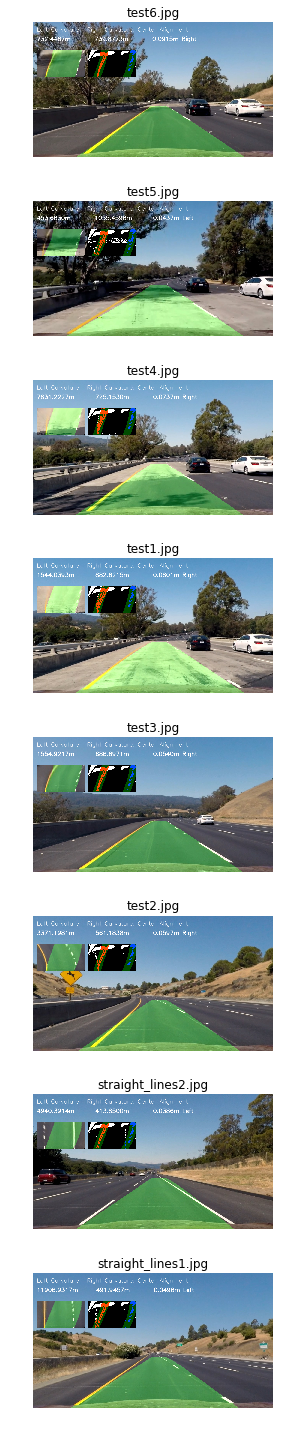

In [90]:
lane_finder = LaneFinder(src, dst, mtx, dist)
plot_all_testimgs(lane_finder.process_frame)

# Test on Video

In [84]:
from moviepy.editor import VideoFileClip
pipeline = LaneFinder(src, dst, mtx, dist)
write_output_path = 'output_video/challange.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(0,1)
challange_clip = clip1.fl_image(pipeline.process_frame)
%time challange_clip.write_videofile(write_output_path, audio=False)

[MoviePy] >>>> Building video output_video/challange.mp4
[MoviePy] Writing video output_video/challange.mp4


100%|██████████| 485/485 [02:22<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/challange.mp4 

CPU times: user 2min 22s, sys: 21.7 s, total: 2min 44s
Wall time: 2min 23s
